In [nb/hod/hod_seed.ipynb](https://github.com/changhoonhahn/eMaNu/blob/4d7b373835ab46842a310cb45195b7f1acbe6929/nb/hod/hod_seed.ipynb), I found that using multiple HOD seeds reduces the differences among ${\rm d}B_g$ along different RSD directions. In this notebook I will examine whether using multiple HOD seeds improves stability/convergence of ${\rm d}B_g/M_\nu$ and also agreement among the different methods. 

In [1]:
import os 
import h5py 
import numpy as np
# --- eMaNu --- 
from emanu import obvs as Obvs

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
kf = 2.*np.pi/1000. # fundmaentla mode
kmax = 0.5

In [4]:
def dBkdMnu(log=False, rsd='all', seed=0, flag='reg', z=0, dmnu='fin', silent=True):
    ''' calculate d B(k)/d theta using quijote HOD simulations run on theta+ and theta- with finite differences. 

    :param theta: 
        string that specifies the parameter to take the 
        derivative by. 

    :param log: (default: False) 
        boolean that specifies whether to return dB/dtheta or dlogB/dtheta 
   
    :param rsd: (default: 'all') 
        rsd kwarg that specifies rsd set up for B(k). 
        If rsd == 'all', include 3 RSD directions. 
        If rsd in [0,1,2] include one of the directions
    
    :param flag: (default: None) 
        kwarg specifying the flag for B(k). 
        If `flag is None`, include paired-fixed and regular N-body simulation.(not advised)
        If `flag == 'ncv'` only include paired-fixed. 
        If `flag == 'reg'` only include regular N-body

    :param dmnu: (default: 'fin') 
        stirng that specifies the derivative method for dB/dMnu. Default 
        is finite difference method using 0, 0.1, 0.2, 0.4 eVs

    :return k1, k2, k3, dbk
        triangle sides and derivatives
    '''
    quijote_thetas = {
            'Mnu': [0.1, 0.2, 0.4], # +, ++, +++ 
            'Ob': [0.048, 0.050],   # others are - + 
            'Ob2': [0.047, 0.051],   # others are - + 
            'Om': [0.3075, 0.3275],
            'h': [0.6511, 0.6911],
            'ns': [0.9424, 0.9824],
            's8': [0.819, 0.849], 
            'logMmin': [13.6, 13.7], 
            'sigma_logM': [0.18, 0.22], 
            'logM0': [13.8, 14.2],
            'alpha': [0.9, 1.3], 
            'logM1': [13.8, 14.2]}
    
    if isinstance(seed, int): 
        seeds = [seed]
    else: 
        seeds = seed
    
    c_dbk = 0. 
    if not silent: print("--- calculating dB/dMnu using %s ---" % dmnu)
    # derivative w.r.t. Mnu using 0, 0.1, 0.2, 0.4 eV
    tts = ['fiducial_za', 'Mnu_p', 'Mnu_pp', 'Mnu_ppp']
    if dmnu == 'p': 
        coeffs = [-1., 1., 0., 0.]  # derivative at 0.05eV
        h = 0.1
    elif dmnu == 'pp': 
        coeffs = [-1., 0., 1., 0.]  # derivative at 0.1eV
        h = 0.2
    elif dmnu == 'ppp': 
        coeffs = [-1., 0., 0., 1.]  # derivative at 0.2eV
        h = 0.4
    elif dmnu == 'fin0': 
        coeffs = [-3., 4., -1., 0.] # finite difference coefficient
        h = 0.2
    elif dmnu == 'fin': 
        coeffs = [-21., 32., -12., 1.] # finite difference coefficient
        h = 1.2
    elif dmnu == 'fin_2lpt': 
        tts = ['fiducial', 'Mnu_p', 'Mnu_pp', 'Mnu_ppp'] # use ZA inital conditions
        coeffs = [-21., 32., -12., 1.] # finite difference coefficient
        h = 1.2
    elif dmnu == '0.2eV_2LPTZA': # derivative @ 0.2 eV (not using 0.0eV which has 2LPT IC) 
        coeffs = [0., -20., 15., 5.] 
        h = 3. 
    elif dmnu == '0.2eV_ZA': # derivative @ 0.2 eV (not using 0.0eV which has 2LPT IC) 
        coeffs = [15., -80., 60., 5.] 
        h = 6. 
    else: 
        raise NotImplementedError
            

    for i_tt, tt, coeff in zip(range(len(tts)), tts, coeffs): 
        _bk_seeds = [] 
        for seed in seeds: 
            quij = Obvs.quijhod_Bk(tt, z=z, flag=flag, rsd=rsd, seed=seed, silent=silent)
            _bk_seeds.append(quij['b123'])
          
        _bk_tt = np.concatenate(_bk_seeds, axis=0)
        
        if i_tt == 0: dbk = np.zeros(_bk_tt.shape) 
        if log: _bk_tt = np.log(_bk_tt) 
        dbk += coeff * _bk_tt 

    return quij['k1'], quij['k2'], quij['k3'], dbk / h + c_dbk 

In [5]:
i_k, j_k, l_k, _ = dBkdMnu(log=False, rsd=0, seed=range(5), flag='reg', z=0, dmnu='fin', silent=True)
bklim = ((i_k*kf <= kmax) & (j_k*kf <= kmax) & (l_k*kf <= kmax)) # k limit

/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


(500, 6350)


/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


(2500, 6350)


/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


(500, 6350)


/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


(2500, 6350)


/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


(500, 6350)


/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


(2500, 6350)


Text(0.5, 0, 'triangles')

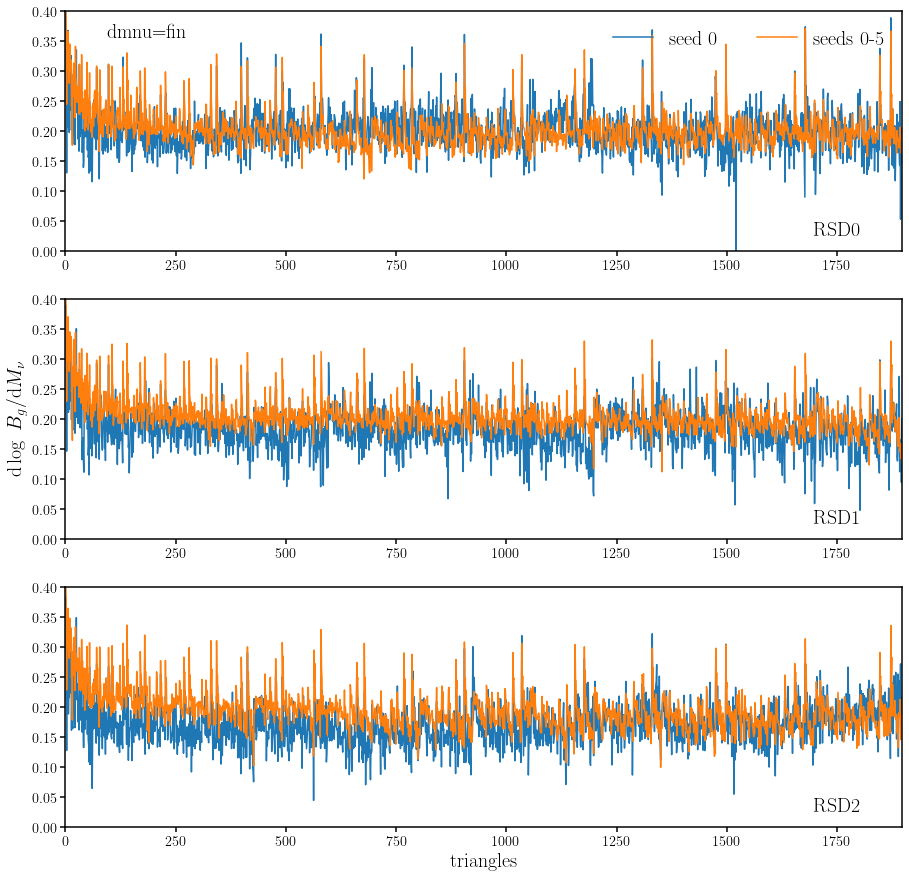

In [6]:
fig = plt.figure(figsize=(15,15))
for rsd in [0, 1, 2]: 
    sub = fig.add_subplot(3,1,rsd+1)

    _, _, _, _dbk = dBkdMnu(log=True, rsd=rsd, seed=0, flag='reg', dmnu='fin')
    print(_dbk.shape)
    sub.plot(np.average(_dbk, axis=0)[bklim], c='C0', label='seed 0')
    
    _, _, _, _dbk = dBkdMnu(log=True, rsd=rsd, seed=range(5), flag='reg', dmnu='fin')
    print(_dbk.shape)
    sub.plot(np.average(_dbk, axis=0)[bklim], c='C1', label='seeds 0-5')
    sub.text(0.95, 0.05, 'RSD%i' % rsd, ha='right', va='bottom', transform=sub.transAxes, fontsize=20)

    if rsd == 0: 
        sub.text(0.05, 0.95, 'dmnu=fin', ha='left', va='top', transform=sub.transAxes, fontsize=20)
        sub.legend(loc='upper right', ncol=3, fontsize=20)
    elif rsd == 1:
        sub.set_ylabel(r'${\rm d} \log~B_g/ {\rm d} M_\nu$', fontsize=20)
    sub.set_xlim(0, np.sum(bklim))
    sub.set_ylim(0., 0.4)
sub.set_xlabel('triangles', fontsize=20)

/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log
/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log
/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log
/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log
/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log
/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


Text(0.5, 0, 'triangles')

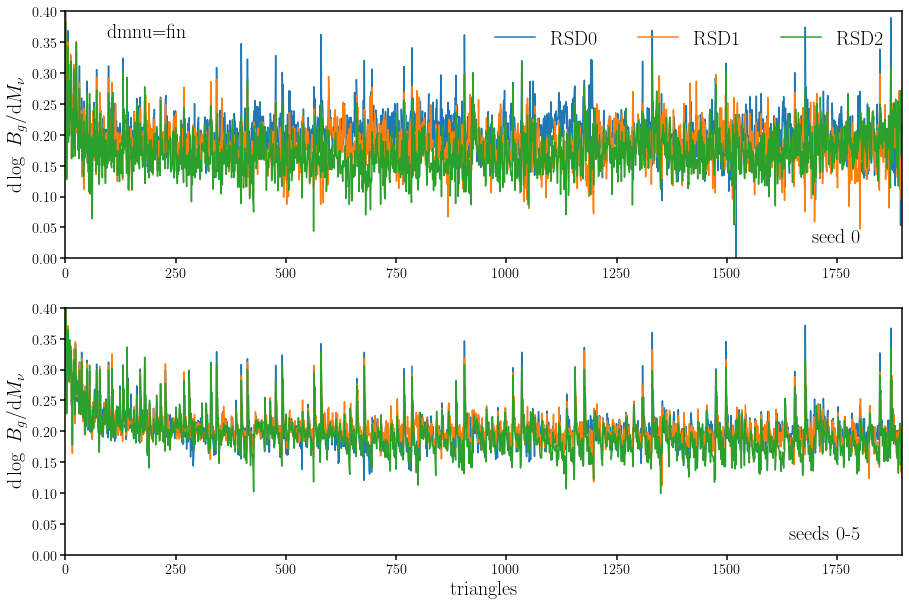

In [7]:
fig = plt.figure(figsize=(15,10))

sub = fig.add_subplot(211)
for rsd in [0, 1, 2]: 
    _, _, _, _dbk = dBkdMnu(log=True, rsd=rsd, seed=0, flag='reg', dmnu='fin')
    sub.plot(np.average(_dbk, axis=0)[bklim], c='C%i' % rsd, label='RSD%i' % rsd)
sub.text(0.05, 0.95, 'dmnu=fin', ha='left', va='top', transform=sub.transAxes, fontsize=20)
sub.text(0.95, 0.05, 'seed 0', ha='right', va='bottom', transform=sub.transAxes, fontsize=20)

sub.legend(loc='upper right', ncol=3, fontsize=20)
sub.set_ylabel(r'${\rm d} \log~B_g/ {\rm d} M_\nu$', fontsize=20)
sub.set_xlim(0, np.sum(bklim))
sub.set_ylim(0., 0.4)

    
sub = fig.add_subplot(212)
for rsd in [0, 1, 2]:     
    _, _, _, _dbk = dBkdMnu(log=True, rsd=rsd, seed=range(5), flag='reg', dmnu='fin')
    sub.plot(np.average(_dbk, axis=0)[bklim], c='C%i' % rsd, label='RSD%i' % rsd)
sub.text(0.95, 0.05, 'seeds 0-5', ha='right', va='bottom', transform=sub.transAxes, fontsize=20)
sub.set_ylabel(r'${\rm d} \log~B_g/ {\rm d} M_\nu$', fontsize=20)
sub.set_xlim(0, np.sum(bklim))
sub.set_ylim(0., 0.4)
sub.set_xlabel('triangles', fontsize=20)

/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log
/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


Text(0.5, 0, 'triangles')

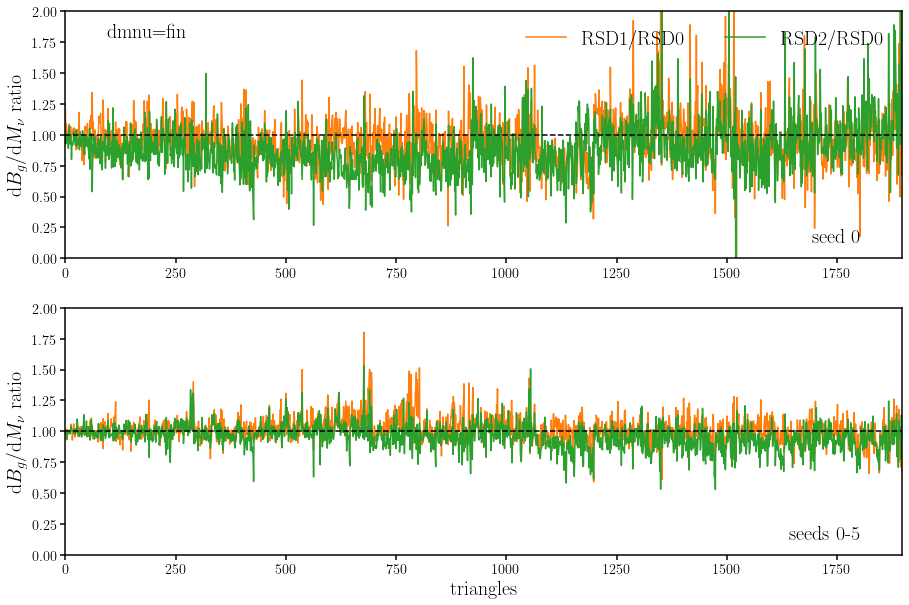

In [8]:
fig = plt.figure(figsize=(15,10))

sub = fig.add_subplot(211)
_, _, _, _dbk0 = dBkdMnu(rsd=0, seed=0, flag='reg', dmnu='fin')
for rsd in [1, 2]: 
    _, _, _, _dbk = dBkdMnu(rsd=rsd, seed=0, flag='reg', dmnu='fin')
    sub.plot(np.average(_dbk, axis=0)[bklim]/np.average(_dbk0, axis=0)[bklim], c='C%i' % rsd, label='RSD%i/RSD0' % rsd)
sub.plot([0., np.sum(bklim)], [1., 1.], c='k', ls='--')
sub.text(0.05, 0.95, 'dmnu=fin', ha='left', va='top', transform=sub.transAxes, fontsize=20)
sub.text(0.95, 0.05, 'seed 0', ha='right', va='bottom', transform=sub.transAxes, fontsize=20)

sub.legend(loc='upper right', ncol=3, fontsize=20)
sub.set_ylabel(r'${\rm d} B_g/ {\rm d} M_\nu$ ratio', fontsize=20)
sub.set_xlim(0, np.sum(bklim))
sub.set_ylim(0., 2.)

    
sub = fig.add_subplot(212)
_, _, _, _dbk0 = dBkdMnu(log=True, rsd=0, seed=range(5), flag='reg', dmnu='fin')

for rsd in [1, 2]:     
    _, _, _, _dbk = dBkdMnu(log=True, rsd=rsd, seed=range(5), flag='reg', dmnu='fin')
    sub.plot(np.average(_dbk, axis=0)[bklim]/np.average(_dbk0, axis=0)[bklim], c='C%i' % rsd, label='RSD%i/RSD0' % rsd)
sub.plot([0., np.sum(bklim)], [1., 1.], c='k', ls='--')
sub.text(0.95, 0.05, 'seeds 0-5', ha='right', va='bottom', transform=sub.transAxes, fontsize=20)
sub.set_ylabel(r'${\rm d} B_g/ {\rm d} M_\nu$ ratio', fontsize=20)
sub.set_xlim(0, np.sum(bklim))
sub.set_ylim(0., 2.)
sub.set_xlabel('triangles', fontsize=20)

/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


(1500, 6350)


/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


(7500, 6350)


/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


(7500, 6350)


Text(0, 0.5, '${\\rm d} B_g/ {\\rm d} M_\\nu$')

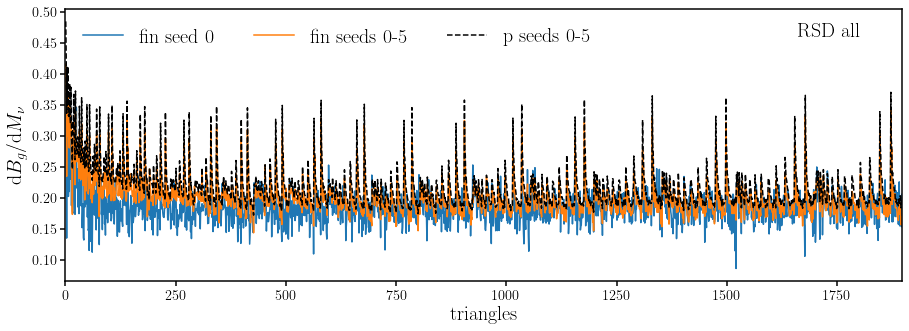

In [9]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

_, _, _, _dbk = dBkdMnu(log=True, rsd='all', seed=0, flag='reg', dmnu='fin')
sub.plot(np.average(_dbk, axis=0)[bklim], c='C0', ls='-', label='fin seed 0')
print(_dbk.shape)

_, _, _, _dbk = dBkdMnu(log=True, rsd='all', seed=range(5), flag='reg', dmnu='fin')
sub.plot(np.average(_dbk, axis=0)[bklim], c='C1', ls='-', label='fin seeds 0-5')
print(_dbk.shape)

_, _, _, _dbk = dBkdMnu(log=True, rsd='all', seed=range(5), flag='reg', dmnu='p')
sub.plot(np.average(_dbk, axis=0)[bklim], c='k', ls='--', label='p seeds 0-5')
print(_dbk.shape)
    
sub.legend(loc='upper left', ncol=3, fontsize=20)
sub.text(0.95, 0.95, 'RSD all', ha='right', va='top', transform=sub.transAxes, fontsize=20)
sub.set_xlabel('triangles', fontsize=20)
sub.set_xlim(0, np.sum(bklim))
sub.set_ylabel(r'${\rm d} B_g/ {\rm d} M_\nu$', fontsize=20)
#sub.set_yscale('log')

/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


(1500, 6350)


/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


(7500, 6350)


/Users/ChangHoon/opt/anaconda3/envs/emanu/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log


(7500, 6350)


Text(0, 0.5, '${\\rm d} B_g/ {\\rm d} M_\\nu$')

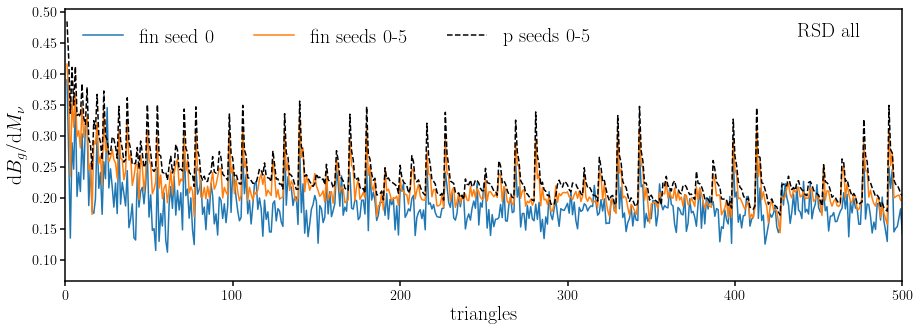

In [10]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

_, _, _, _dbk = dBkdMnu(log=True, rsd='all', seed=0, flag='reg', dmnu='fin')
sub.plot(np.average(_dbk, axis=0)[bklim], c='C0', ls='-', label='fin seed 0')
print(_dbk.shape)

_, _, _, _dbk = dBkdMnu(log=True, rsd='all', seed=range(5), flag='reg', dmnu='fin')
sub.plot(np.average(_dbk, axis=0)[bklim], c='C1', ls='-', label='fin seeds 0-5')
print(_dbk.shape)

_, _, _, _dbk = dBkdMnu(log=True, rsd='all', seed=range(5), flag='reg', dmnu='p')
sub.plot(np.average(_dbk, axis=0)[bklim], c='k', ls='--', label='p seeds 0-5')
print(_dbk.shape)
    
sub.legend(loc='upper left', ncol=4, fontsize=20)
sub.text(0.95, 0.95, 'RSD all', ha='right', va='top', transform=sub.transAxes, fontsize=20)
sub.set_xlabel('triangles', fontsize=20)
sub.set_xlim(0, 500)
sub.set_ylabel(r'${\rm d} B_g/ {\rm d} M_\nu$', fontsize=20)
#sub.set_yscale('log')